In [1]:
import bayesianchangepoint as bcp
import matplotlib.pyplot as plt
from scipy.stats import beta
import numpy as np
%matplotlib inline
fig_width = 15

In [2]:
def binomial_motion(N_trials, seed, p_1, p_2):

    np.random.seed(seed)
    
    trials = np.arange(N_trials)
    p = np.random.rand(N_trials, 3)
    
    rand = p_1
    p[-1, 1] = rand
    p[:, 2] = np.zeros(N_trials)
    
    for trial in trials:
        if trial == int(N_trials/2) :
            p[trial, 2] = 1
            rand = p_2

        p[trial, 1] = (1 - p[trial, 2])*p[trial-1, 1] + p[trial, 2] * rand # probability
        p[trial, 0] =  p[trial, 1] > np.random.rand(1) # binomial

    return p

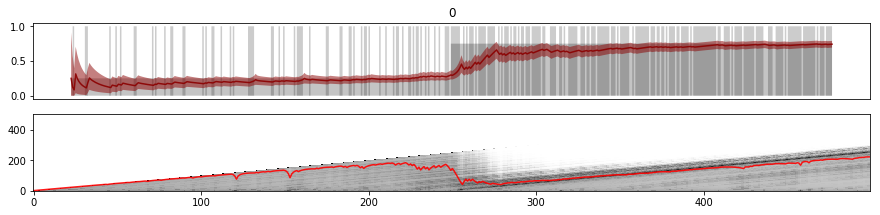

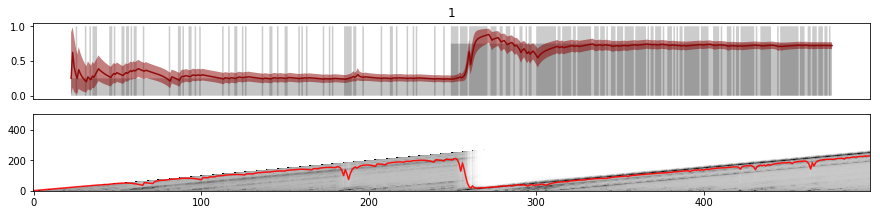

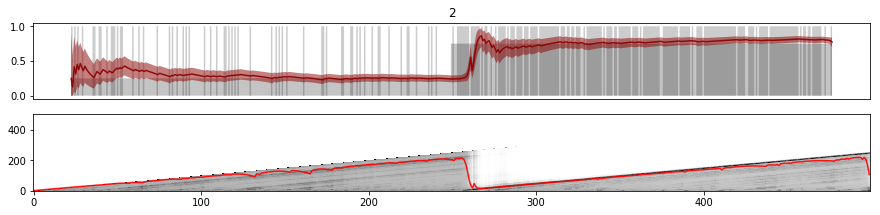

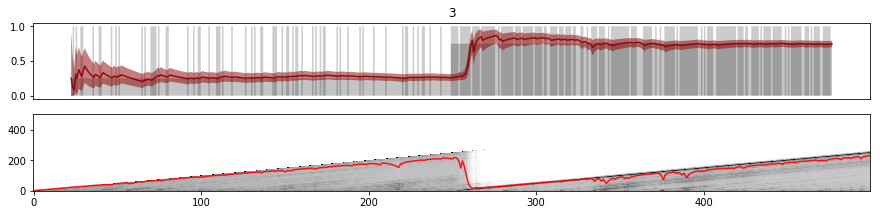

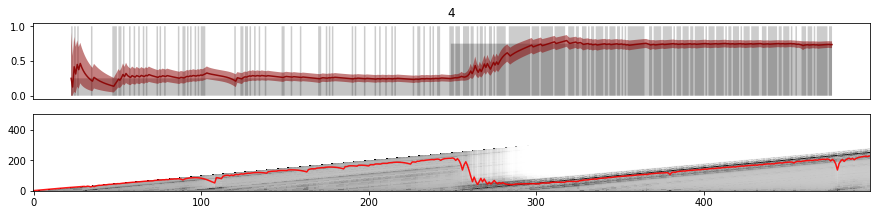

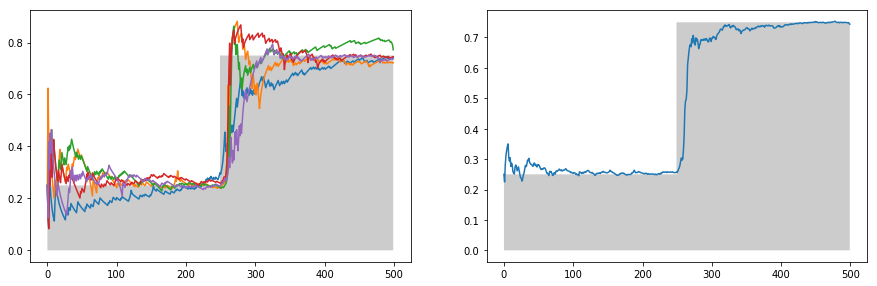

In [3]:
N_trials = 500
max_run_length=N_trials
n_seed = 5

PHAT = np.random.rand(N_trials, n_seed)
for seed in range(n_seed) :
    p = binomial_motion(N_trials, seed, p_1=0.25, p_2=0.75)

    fig, axs = plt.subplots(2, 1, figsize=(fig_width, (fig_width)/((1.6180*6)/2)))

    axs[0].fill_between(range(N_trials), np.zeros_like(p[:,0]), p[:,0], lw=0, alpha=.20, facecolor='k', step='pre')
    axs[0].fill_between(range(N_trials), np.zeros_like(p[:,1]), p[:,1], lw=0, alpha=.23, facecolor='k', step='pre')


    p_bar, r, beliefs = bcp.inference(p[:, 0], h=1/250, p0=.25)
    p_hat, r_hat = bcp.readout(p_bar, r, beliefs, mode='expectation')
    p_low, p_sup = np.zeros_like(p_hat), np.zeros_like(p_hat)
    for i_trial in range(N_trials):
        p_low[i_trial], p_sup[i_trial] = beta.ppf([.05, .95], a=p_hat[i_trial]*r_hat[i_trial], b=(1-p_hat[i_trial])*r_hat[i_trial])

    PHAT[:, seed] = p_hat
    axs[0].plot(range(N_trials), p_hat, c='darkred',  lw=1.5, alpha=.9)
    axs[0].fill_between(range(N_trials), p_sup, p_low, lw=.5, alpha=.50, facecolor='darkred')
    axs[1].plot(range(N_trials), r_hat, lw=1.5, alpha=.9, c='r')

    axs[1].imshow(np.log(beliefs[:max_run_length, :]+ 1.e-5), cmap='Greys')
    axs[1].set_ylim(-.05*N_trials, N_trials + (.05*N_trials))
    axs[1].axis('tight')
    axs[0].set_title(seed)
    axs[0].set_xticks([])
    
    plt.show()

fig, axs = plt.subplots(1, 2, figsize=(fig_width, (fig_width)/((1.6180*2))))

axs[0].plot(PHAT)
axs[0].fill_between(range(N_trials), np.zeros_like(p[:,1]), p[:,1], lw=0, alpha=.2, facecolor='k', step='pre')

p_mean = []
for trial in range(N_trials) :
    p_mean.append(np.nanmean(PHAT[trial, :]))

axs[1].plot(p_mean)
axs[1].fill_between(range(N_trials), np.zeros_like(p[:,1]), p[:,1], lw=0, alpha=.2, facecolor='k', step='pre')

plt.show()

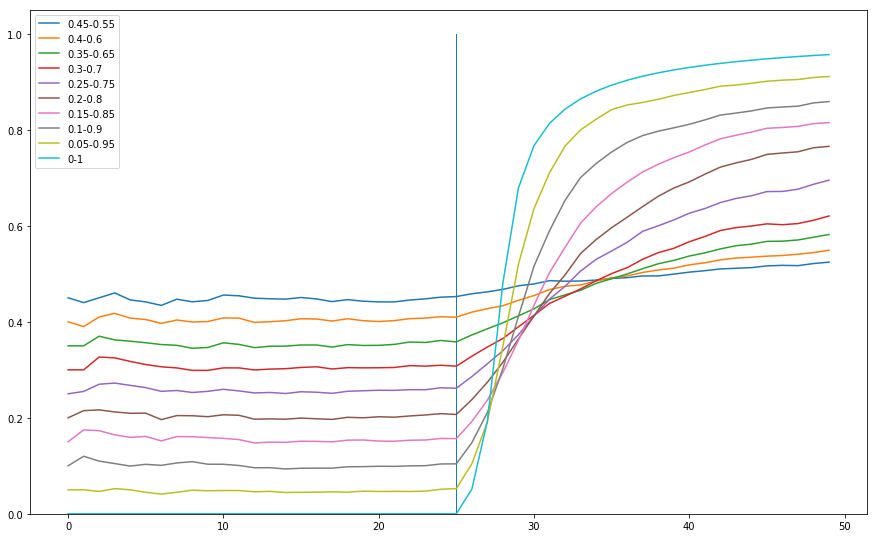

In [4]:
plt.figure(figsize=(fig_width, (fig_width)/((1.6180))))

n_seed = 100
N_trials = 50
P_1 = [0.45,0.40,0.35,0.30,0.25,0.20,0.15,0.10,0.05,0]
P_2 = [0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,1]

for x in range(len(P_1)) :
    p1 = P_1[x]
    p2 = P_2[x]
    PHAT = np.random.rand(N_trials, n_seed)
    for seed in range(n_seed) :
        p = binomial_motion(N_trials, seed, p_1=p1, p_2=p2)
        p_bar, r, beliefs = bcp.inference(p[:, 0], h=1/100, p0=p1)
        p_hat, r_hat = bcp.readout(p_bar, r, beliefs, mode='expectation')
        PHAT[:, seed] = p_hat

    p_mean = []
    for trial in range(N_trials) :
        p_mean.append(np.nanmean(PHAT[trial, :]))
    
    plt.plot(p_mean, label='%s-%s'%(p1,p2))
plt.bar(N_trials/2, 1, 0.1, 0)
plt.legend()
plt.show()

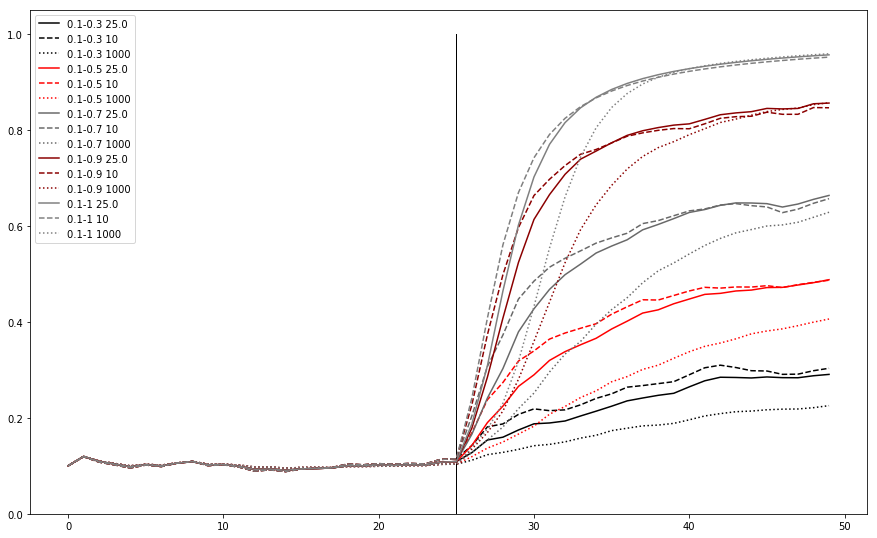

In [5]:
plt.figure(figsize=(fig_width, (fig_width)/((1.6180))))

n_seed = 100
N_trials = 50
color = ['k', 'r', 'dimgrey', 'darkred', 'grey']
#P_1 = [0.40,0.30,0.20,0.10,0]
P_2 = [0.30,0.50,0.70,0.90,1]
marker = ['-', '--', ':']
for x in range(len(P_2)) :
    p1 = 0.1
    p2 = P_2[x]
    m = 0
    for tau in [N_trials/2,10,1000] :
        PHAT = np.random.rand(N_trials, n_seed)
        for seed in range(n_seed) :
            p = binomial_motion(N_trials, seed, p_1=p1, p_2=p2)
            p_bar, r, beliefs = bcp.inference(p[:, 0], h=1/tau, p0=p1)
            p_hat, r_hat = bcp.readout(p_bar, r, beliefs, mode='expectation')
            PHAT[:, seed] = p_hat

        p_mean = []
        for trial in range(N_trials) :
            p_mean.append(np.nanmean(PHAT[trial, :]))

        plt.plot(p_mean, c=color[x], linestyle=marker[m], label='%s-%s %s'%(p1,p2, tau))
        m=m+1
plt.bar(N_trials/2, 1, 0.1, 0, color='k')
plt.legend()
plt.show()